In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.constants import c
from scipy.signal import fftconvolve
from scipy.signal.windows import hamming, blackman, kaiser
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import csv
from funcs import read_iq_bin, notch_filter, gen_chirp_to_csv_rep, spectrogram_data, extract_signals_from_bin, read_complex_csv, gen_chirp_to_csv, gen_nlfm_to_csv
pulse_width = 5000
pulse_separation = 0
B = 1e6
fs = 25e6

def get_fft_data(complex_data, fs):
    fft_data = np.fft.fft(complex_data)
    fft_db = 20*np.log10(np.abs(fft_data))
    fft_freqs = np.fft.fftfreq(len(fft_data),1/fs)

    return fft_db, fft_freqs

result = gen_chirp_to_csv("../sweep_sim.csv", -B, B, pulse_width, pulse_separation, 1, fs)

# Baseband signal

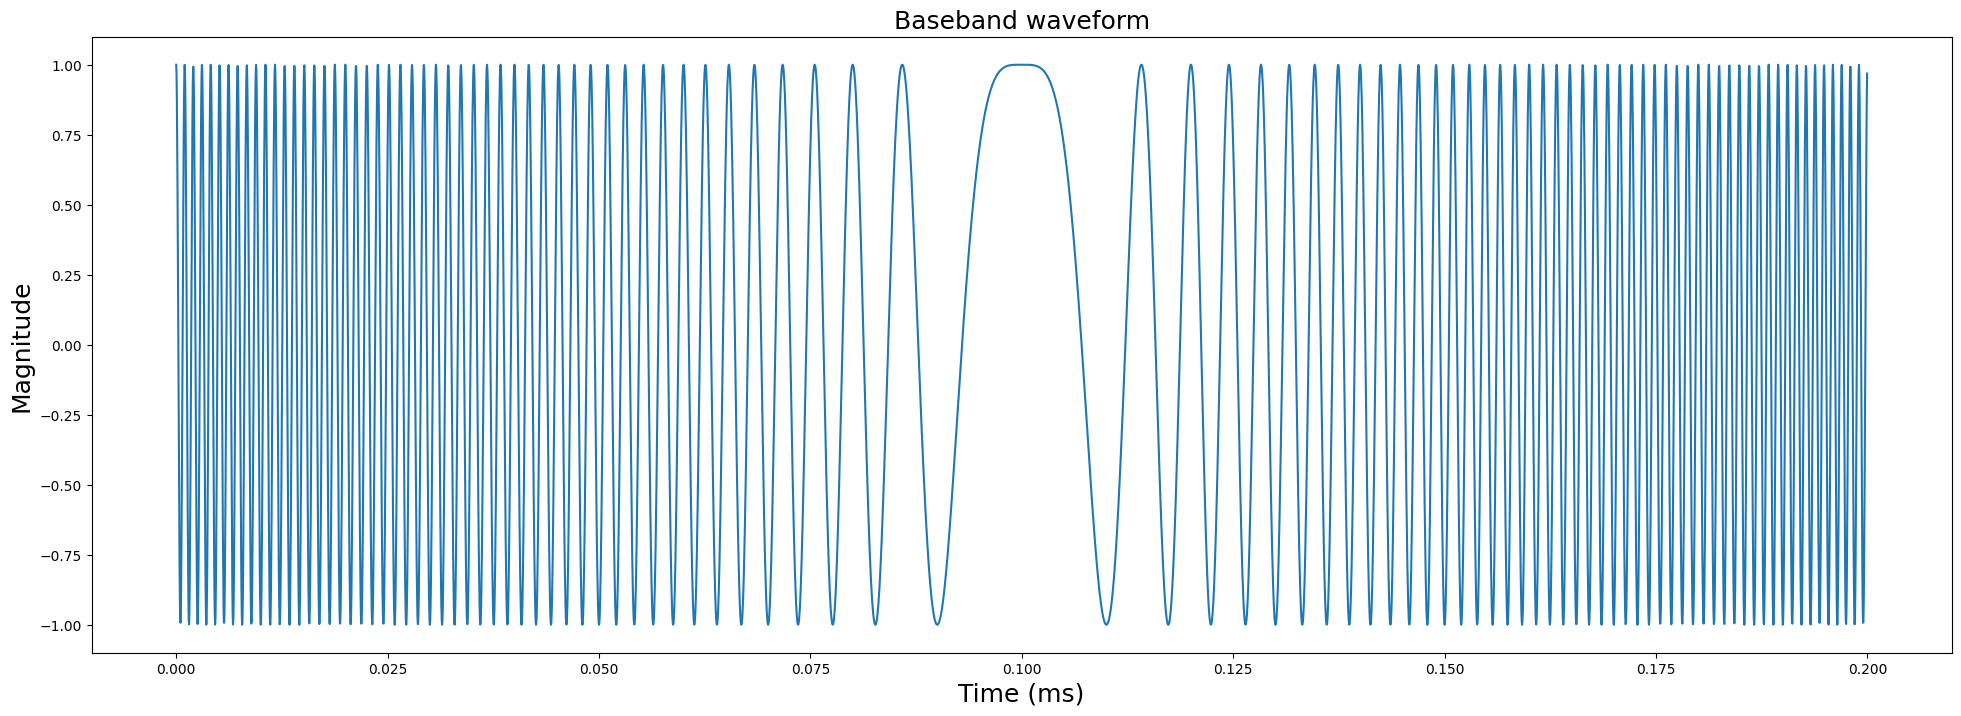

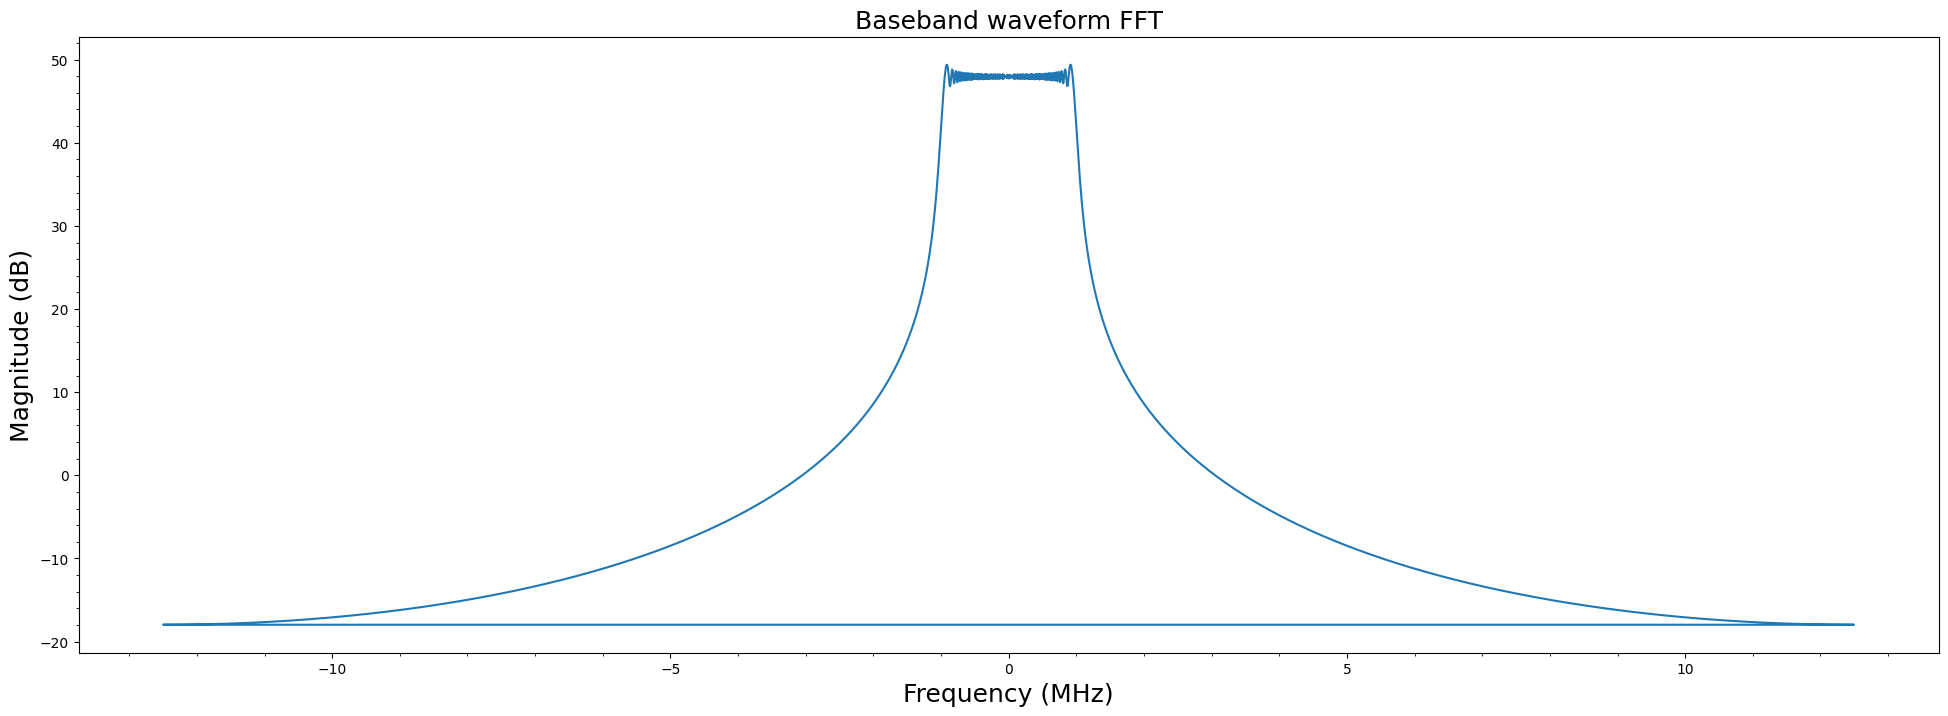

In [71]:
template_signal = read_complex_csv("../sweep_sim.csv")
template_signal = template_signal[0:pulse_width]

seconds = np.arange(len(template_signal))/fs * 1000 # ms
plt.figure(figsize=(24,8))
plt.plot(seconds,template_signal)
plt.title("Baseband waveform", fontsize=18)
plt.xlabel("Time (ms)", fontsize=18)
plt.ylabel("Magnitude", fontsize=18)
plt.show()

fft_db, fft_freqs = get_fft_data(template_signal,fs)
fft_freqs = fft_freqs/1000000 # MHz
plt.figure(figsize=(24,8))
plt.plot(fft_freqs,fft_db)
plt.title("Baseband waveform FFT", fontsize=18)
plt.xlabel("Frequency (MHz)", fontsize=18)
plt.ylabel("Magnitude (dB)", fontsize=18)
plt.minorticks_on()
plt.show()

# Homodyne

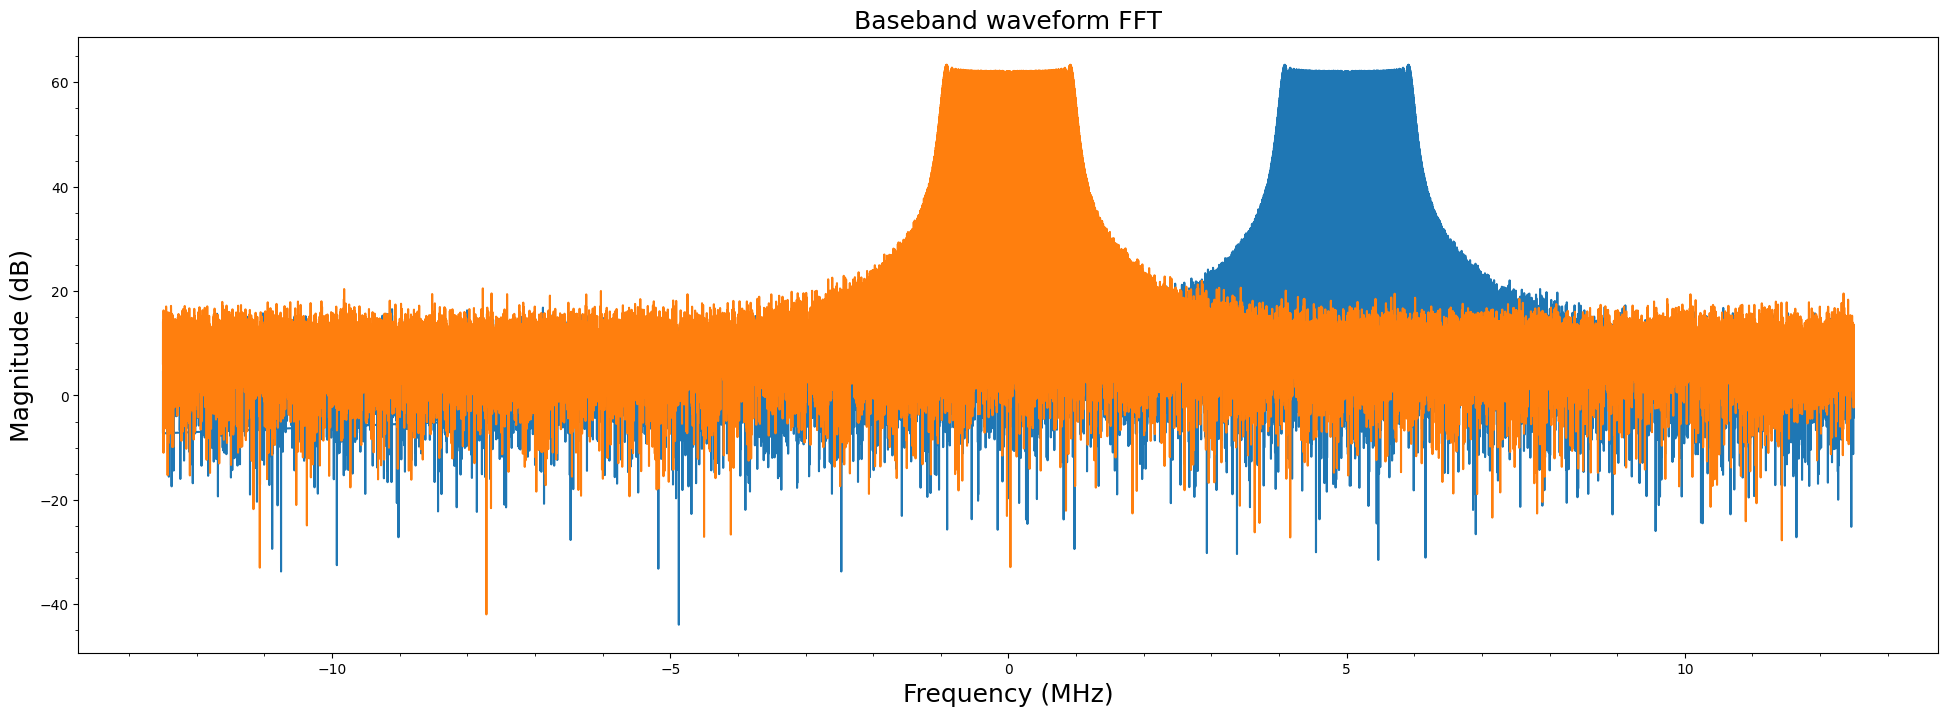

In [68]:
template_signal = read_complex_csv("../sweep_sim.csv")
template_signal = template_signal[0:pulse_width]
fs = 25e6


# Generate pulses
num_pulses=5
pulses_arr = []
for i in range(num_pulses):
    pulses_arr.extend(template_signal)
pulses_arr = np.array(pulses_arr)

# LO frequency
t = np.arange(len(pulses_arr)) /fs
LO_freq = 5e6
I = np.cos(2 * np.pi * LO_freq * t)  # In-phase component (cosine)
Q = np.sin(2 * np.pi * LO_freq * t)  # Quadrature component (sine)
LO_arr = I + 1j*Q
noise_IQ = 0.01 * (np.random.randn(len(LO_arr)) + 1j * np.random.randn(len(LO_arr)))
LO_arr = LO_arr + noise_IQ

upmixed = LO_arr * pulses_arr
downmixed = upmixed * np.conj(LO_arr)

fft_upmixed, fft_freqs = get_fft_data(upmixed,fs)
fft_downmixed, fft_freqs = get_fft_data(downmixed,fs)
fft_freqs = fft_freqs/1000000 # MHz

plt.figure(figsize=(24,8))
plt.plot(fft_freqs,fft_upmixed)
plt.plot(fft_freqs,fft_downmixed)
plt.title("Baseband waveform FFT", fontsize=18)
plt.xlabel("Frequency (MHz)", fontsize=18)
plt.ylabel("Magnitude (dB)", fontsize=18)
plt.minorticks_on()
plt.show()


# Reflection Friis

atten: 3.8189954353802406e-06


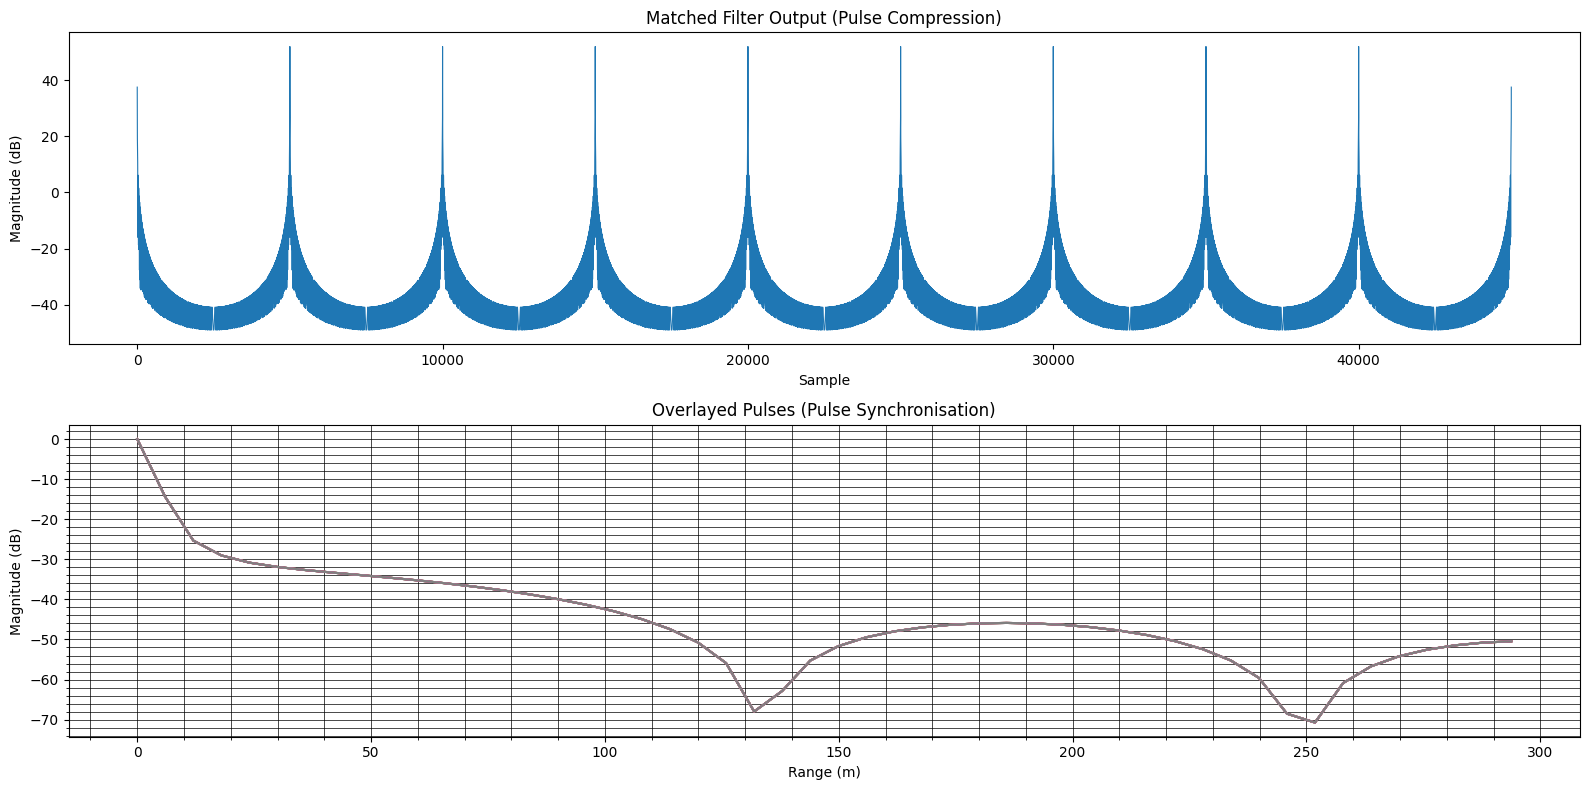

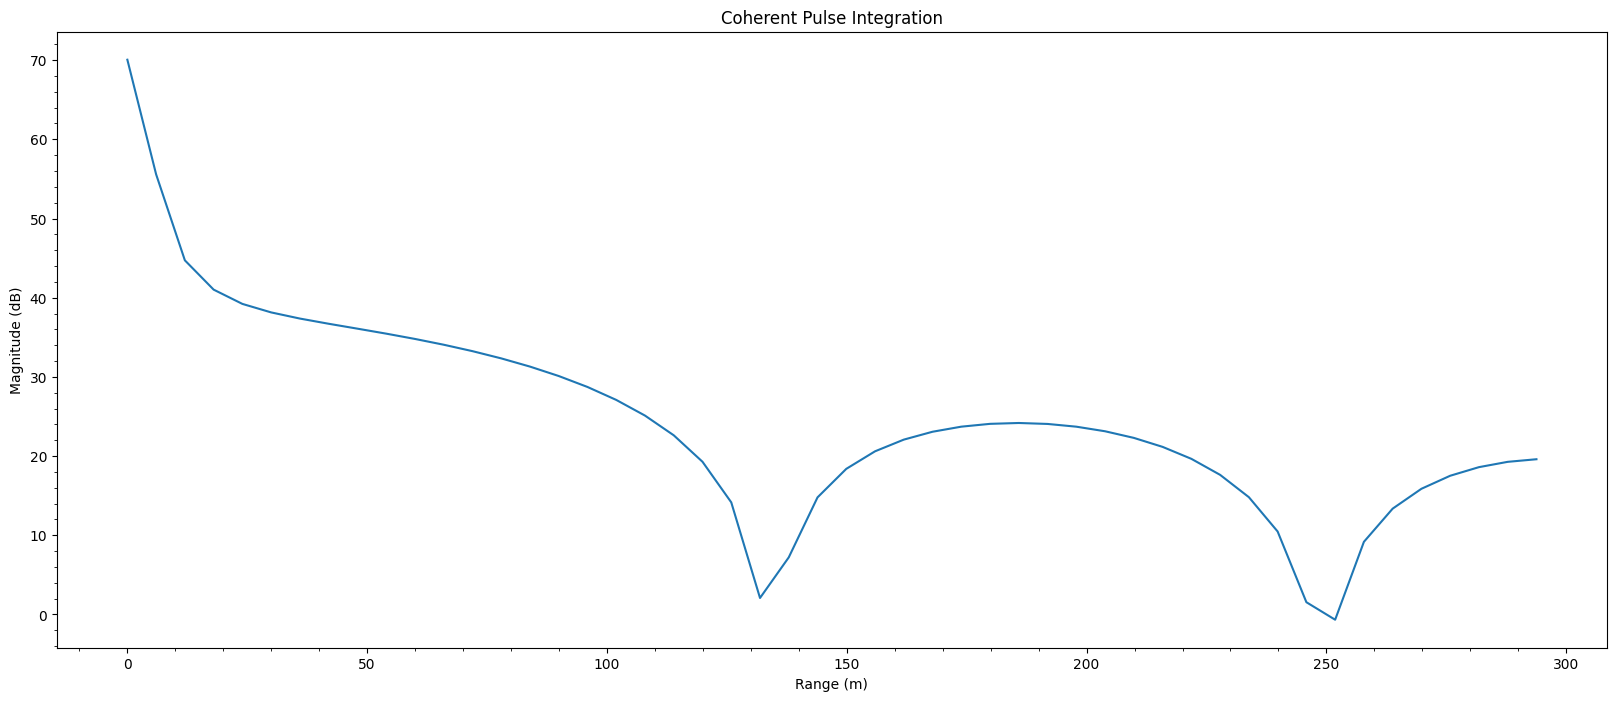

In [27]:
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]
fs = 25e6
d = 18
Pt_dbm = 12.5
Pt_lin = 10 ** (Pt_dbm / 10) * 0.001
G_db = 6
G_lin = 10 ** (G_db / 10)
fc = 2.7e9
lam = c/fc
Pr_lin = (Pt_lin*G_lin*G_lin*lam*lam)/(4*np.pi*d * 4*np.pi*d)
atten = Pr_lin/Pt_lin
print(f"atten: {atten}")

# Generate pulses
num_pulses=10
pulses_arr = []
for i in range(num_pulses):
    pulses_arr.extend(template_signal)
pulses_arr = np.array(pulses_arr)
pulses_arr_xtalk = 0.1*pulses_arr

idx = 3
pulses_arr_shifted = np.zeros_like(pulses_arr)
pulses_arr_shifted[idx:] = atten*pulses_arr[:-idx]
signal_with_refl = pulses_arr_xtalk + pulses_arr_shifted
#signal_with_refl += 0.1 * (np.random.randn(len(LO_arr)) + 1j * np.random.randn(len(LO_arr)))

matched_filter = np.conjugate(template_signal[::-1])
window = hamming(len(matched_filter))  # Choose the appropriate window function
window = kaiser(len(matched_filter), 2, sym=True)  # Choose the appropriate window function
matched_filter = matched_filter * window  # Apply the window
xcorr_data = fftconvolve(signal_with_refl, matched_filter, mode='full')
xcorr_data = xcorr_data[5000:-5000] # Artifact at start from mode=full

fig, axs = plt.subplots(2, 1, figsize=(16, 8))
axs[0].plot(20*np.log10(np.abs(xcorr_data)),linewidth=0.8)
axs[0].set_title("Matched Filter Output (Pulse Compression)")
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Magnitude (dB)")

# Extract pulses
xcorr_matrix = []
ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:50]
pulse_sum = np.zeros(50).astype(np.complex128)
while (len(xcorr_data)>0):
    max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
    xcorr_data_plot = xcorr_data[max_idx:max_idx+pulse_width]
    xcorr_data_plot = xcorr_data_plot[0:50]
    if (len(xcorr_data_plot)==50):
        axs[1].plot(ranges,20*np.log10(np.abs(xcorr_data_plot/np.max(xcorr_data_plot))))
        pulse_sum += xcorr_data_plot
        xcorr_data = xcorr_data[pulse_width+pulse_separation:]
        xcorr_matrix.append(xcorr_data_plot)
    else:
        break

#axs[2].set_xticks(ranges)
axs[1].grid(True, which='both')
axs[1].grid(which='minor', linewidth=0.5, color='black')
axs[1].grid(which='major', linewidth=0.5, color='black')
axs[1].minorticks_on()
#plt.setp(axs[2].get_xticklabels(), fontsize=4)
axs[1].set_title("Overlayed Pulses (Pulse Synchronisation)")
axs[1].set_xlabel("Range (m)")
axs[1].set_ylabel("Magnitude (dB)")

plt.tight_layout()
plt.show()

plt.figure(figsize=(20,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum)))
plt.minorticks_on()
plt.title("Coherent Pulse Integration")
plt.xlabel("Range (m)")
plt.ylabel("Magnitude (dB)")
plt.show()


# Reflection Cable

atten: 1e-07


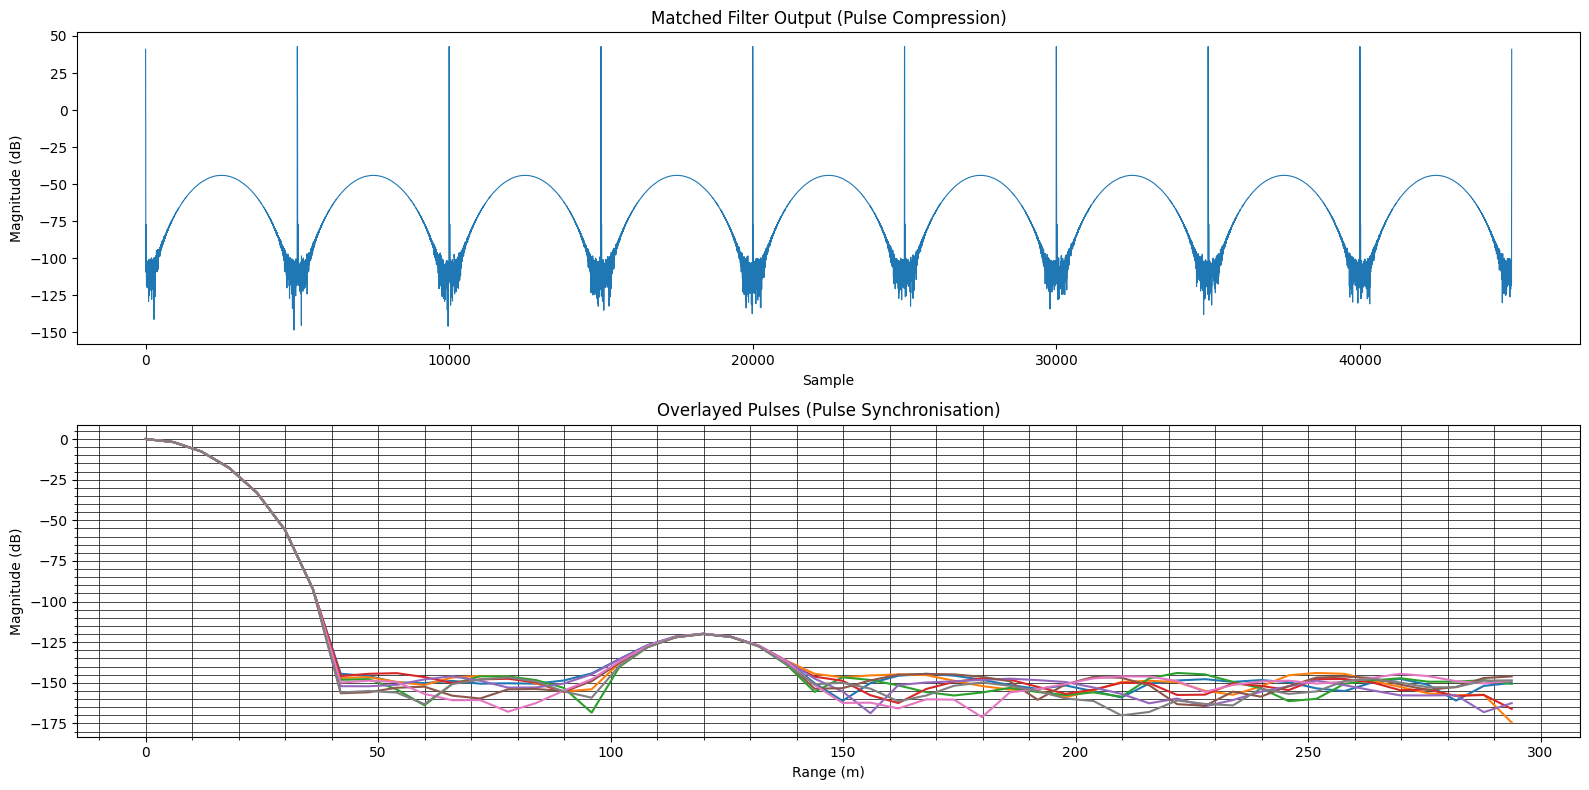

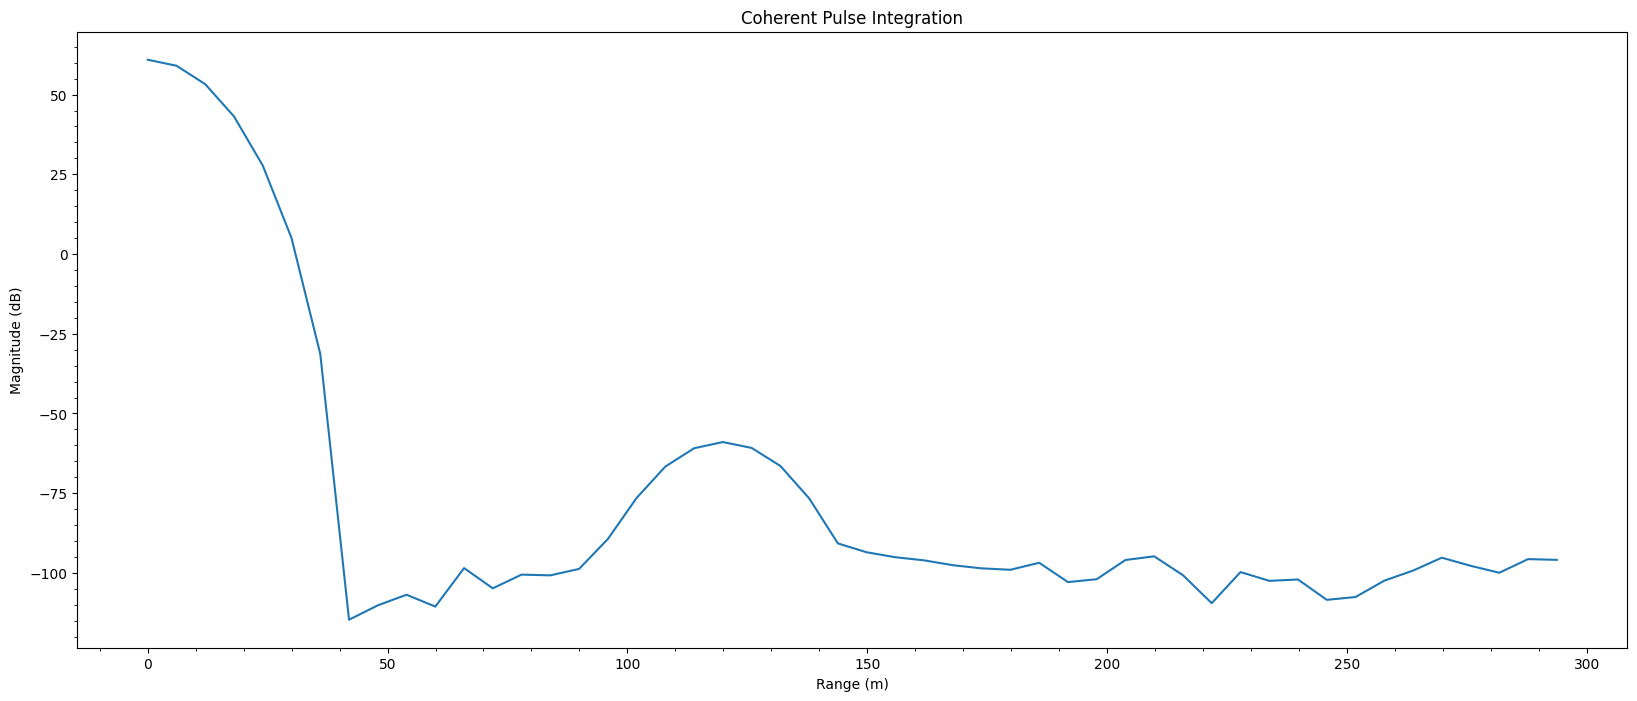

In [41]:
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]
fs = 25e6
d = 250
idx = int(d/c * fs)
atten_dbm = 40
atten_db = atten_dbm + 30
atten_lin = 10 ** (-atten_db / 10)
print(f"atten: {atten_lin}")

# Generate pulses
num_pulses=10
pulses_arr = []
for i in range(num_pulses):
    pulses_arr.extend(template_signal)
pulses_arr = np.array(pulses_arr)
pulses_arr_xtalk = 0.1*pulses_arr


pulses_arr_shifted = np.zeros_like(pulses_arr)
pulses_arr_shifted[idx:] = atten_lin*pulses_arr[:-idx]
signal_with_refl = pulses_arr_xtalk + pulses_arr_shifted
signal_with_refl += 1e-7 * (np.random.randn(len(signal_with_refl)) + 1j * np.random.randn(len(signal_with_refl)))

matched_filter = np.conjugate(template_signal[::-1])
window = hamming(len(matched_filter))  # Choose the appropriate window function
window = kaiser(len(matched_filter), 20, sym=True)  # Choose the appropriate window function
matched_filter = matched_filter * window  # Apply the window
xcorr_data = fftconvolve(signal_with_refl, matched_filter, mode='full')
xcorr_data = xcorr_data[5000:-5000] # Artifact at start from mode=full

fig, axs = plt.subplots(2, 1, figsize=(16, 8))
axs[0].plot(20*np.log10(np.abs(xcorr_data)),linewidth=0.8)
axs[0].set_title("Matched Filter Output (Pulse Compression)")
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Magnitude (dB)")

# Extract pulses
xcorr_matrix = []
ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:50]
pulse_sum = np.zeros(50).astype(np.complex128)
while (len(xcorr_data)>0):
    max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
    xcorr_data_plot = xcorr_data[max_idx:max_idx+pulse_width]
    xcorr_data_plot = xcorr_data_plot[0:50]
    if (len(xcorr_data_plot)==50):
        axs[1].plot(ranges,20*np.log10(np.abs(xcorr_data_plot/np.max(xcorr_data_plot))))
        pulse_sum += xcorr_data_plot
        xcorr_data = xcorr_data[pulse_width+pulse_separation:]
        xcorr_matrix.append(xcorr_data_plot)
    else:
        break

#axs[2].set_xticks(ranges)
axs[1].grid(True, which='both')
axs[1].grid(which='minor', linewidth=0.5, color='black')
axs[1].grid(which='major', linewidth=0.5, color='black')
axs[1].minorticks_on()
#plt.setp(axs[2].get_xticklabels(), fontsize=4)
axs[1].set_title("Overlayed Pulses (Pulse Synchronisation)")
axs[1].set_xlabel("Range (m)")
axs[1].set_ylabel("Magnitude (dB)")

plt.tight_layout()
plt.show()

plt.figure(figsize=(20,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum)))
plt.minorticks_on()
plt.title("Coherent Pulse Integration")
plt.xlabel("Range (m)")
plt.ylabel("Magnitude (dB)")
plt.show()
